In [4]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [6]:
invoice = pd.read_csv('E:\CodeChef\Capstone Project\Cleaned DataSet\CleanedMergedData.csv')

In [7]:
invoice.shape

(936275, 35)

### Calculating service time in Hrs 

In [8]:
invoice['year'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.year
invoice['month'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.month
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice_DateTime"],dayfirst=True)
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard_DateTime"],dayfirst=True)
invoice['Service_Time'] = invoice['Invoice_DateTime'] - invoice['JobCard_DateTime']
invoice['Service_Time_Hrs'] = invoice['Service_Time']/np.timedelta64(1,'h')
invoice['Service_Time_Hrs'].describe()

count    936275.000000
mean         89.878782
std         275.095915
min          -0.009167
25%           4.048611
50%          23.258889
75%          73.230278
max       17769.261389
Name: Service_Time_Hrs, dtype: float64

In [9]:
invoice[invoice['Service_Time_Hrs']<0]

,Unnamed: 0,Unnamed: 0.1,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Clean_Location,Clean_City,Clean_State,JobCard_DateTime,Invoice_DateTime,Service_Time,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
714423,714423,794156,Retail,182085,00:00:00,7167000988,363294,62001,0.0,MARUTI SUZUKI,0.0,SWIFT DZIRE,0.0,Running Repairs,0.0,603103,X085,X085 - SRI MOTORS,NO,0.0,0.0,X085SA1,"Pudupakkam, Padur, Kelambakkam, Thaiyur",Kanchipuram,Tamil Nadu,2016-05-02 15:12:44,2016-05-02 15:12:11,-1 days +23:59:27,NaN,NaN,NaN,363294.0,G2TX,0.0,0.0,2016,5,-0.009167


In [10]:
# dropping a row where service time is in negative
invoice.drop(index=714423,axis=0,inplace=True)

In [11]:
invoice.head()

,Unnamed: 0,Unnamed: 0.1,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Clean_Location,Clean_City,Clean_State,JobCard_DateTime,Invoice_DateTime,Service_Time,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
0,0,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P001,1203.14,73.0,2015,1,477.014722
1,1,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P002,2348.75,6.5,2015,1,477.014722
2,2,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P010,500.06,1.0,2015,1,477.014722
3,3,1,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,"Thane East, Kopri Colony",Thane,Maharashtra,2015-01-02 14:12:18,2015-01-03 10:07:32,0 days 19:55:14,NaN,NaN,NaN,173997.0,P001,804.26,170.0,2015,1,19.920556
4,4,1,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,"Thane East, Kopri Colony",Thane,Maharashtra,2015-01-02 14:12:18,2015-01-03 10:07:32,0 days 19:55:14,NaN,NaN,NaN,173997.0,P011,197.03,1.0,2015,1,19.920556


### Calculation of Life Time Value for each customer over a period of 2015 (1 year) based on "Make" and "Model" of the cars

In [13]:
invoice_15=invoice[invoice["year"]==2015]

In [14]:
invoice_15.shape

(248353, 38)

In [15]:
invoice_15.head()

,Unnamed: 0,Unnamed: 0.1,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Clean_Location,Clean_City,Clean_State,JobCard_DateTime,Invoice_DateTime,Service_Time,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
0,0,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P001,1203.14,73.0,2015,1,477.014722
1,1,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P002,2348.75,6.5,2015,1,477.014722
2,2,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,"Thane Bazar, Thane H.O, Thane R.S.",Thane,Maharashtra,2014-12-13 14:29:43,2015-01-02 11:30:36,19 days 21:00:53,NaN,NaN,NaN,168303.0,P010,500.06,1.0,2015,1,477.014722
3,3,1,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,"Thane East, Kopri Colony",Thane,Maharashtra,2015-01-02 14:12:18,2015-01-03 10:07:32,0 days 19:55:14,NaN,NaN,NaN,173997.0,P001,804.26,170.0,2015,1,19.920556
4,4,1,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,"Thane East, Kopri Colony",Thane,Maharashtra,2015-01-02 14:12:18,2015-01-03 10:07:32,0 days 19:55:14,NaN,NaN,NaN,173997.0,P011,197.03,1.0,2015,1,19.920556


In [17]:
# Calculating frequency of visits & total revenue of a customer for calculation of lifetime value

customer_freq=invoice_15.groupby(["Make","Model","Clean_Location","Customer No."]).agg({"Invoice No":'nunique',"Total Amt Wtd Tax.":'mean',"Service_Time_Hrs":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head()

ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r["Invoice No"] * ltv_make_model_r["Total Amt Wtd Tax."]
ltv_make_model_r.head()

,Make,Model,Clean_Location,Customer No.,Invoice No,Total Amt Wtd Tax.,Service_Time_Hrs,LTV
0,AUDI,A4,"Anandibazar, Ahmednagar City, Ahmednagar H.O, ...",118262,1,1754.440,0.268056,1754.44
1,AUDI,A4,"Block 5,Neyveli, Block 26,Neyveli, Block 18,Ne...",121383,2,6126.835,55.498750,12253.67
2,AUDI,A4,"Deccan Gymkhana, Film Institute, A.R. Shala",98005,1,14549.910,103.956667,14549.91
3,AUDI,A4,Electronics City,113926,1,21834.920,28.306389,21834.92
4,AUDI,A4,"Maravankudiyiruppu, Kottar, Irulappapuram, Eda...",122360,2,1049.570,1.635000,2099.14


### Filtering customer having LTV/Total revenue > 0 

In [18]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [19]:
ltv_make_model_r.shape

(65088, 8)

### Quantile based analysis of LTV to decide threshold

In [20]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 194.9840000000001
0.25 quantile :- 749.4
0.50 quantile :- 3036.01
0.75 quantile :- 8801.681363636362
0.95 quantile :- 33434.124277777766
minimum LTV :- 0.85
maximum LTV :- 2109690.8168778275
mean LTV :- 8739.854409827774


In [21]:
print(ltv_make_model_r[ltv_make_model_r["LTV"]<=3036.01].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV"]>3036.01)&(ltv_make_model_r["LTV"]<=8801.681363636362)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV"]>8801.681363636362].shape)

(32544, 8)
(16272, 8)
(16272, 8)


In [22]:
bins=[-1,3036.01,8801.681363636362,2109690.8168778275]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV"], bins=bins, labels=labels)

In [23]:
ltv_make_model_r["LTV Binned"].value_counts(dropna=False)

Low       32544
High      16272
Medium    16272
Name: LTV Binned, dtype: int64

In [24]:
ltv_make_model_r.dropna(inplace=True)

In [25]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [27]:
le=LabelEncoder()
temp_ltv_make_model_r["Make"]=le.fit_transform(temp_ltv_make_model_r["Make"])
temp_ltv_make_model_r["Model"]=le.fit_transform(temp_ltv_make_model_r["Model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["Clean_Location"]=le.fit_transform(temp_ltv_make_model_r["Clean_Location"])

In [28]:
temp_ltv_make_model_r.head()

,Make,Model,Clean_Location,Customer No.,Invoice No,Total Amt Wtd Tax.,Service_Time_Hrs,LTV,LTV Binned
0,0,7,123,118262,1,1754.440,0.268056,1754.44,1
1,0,7,371,121383,2,6126.835,55.498750,12253.67,0
2,0,7,582,98005,1,14549.910,103.956667,14549.91,0
3,0,7,692,113926,1,21834.920,28.306389,21834.92,0
4,0,7,1648,122360,2,1049.570,1.635000,2099.14,1


In [29]:
X=temp_ltv_make_model_r.drop(["Customer No.","LTV","LTV Binned","Invoice No"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [30]:
list(X)

['Make', 'Model', 'Clean_Location', 'Total Amt Wtd Tax.', 'Service_Time_Hrs']

In [31]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

### Decision Tree Classifier

In [32]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4825
           1       0.87      0.99      0.93      9834
           2       0.77      0.58      0.66      4868

    accuracy                           0.84     19527
   macro avg       0.82      0.79      0.80     19527
weighted avg       0.83      0.84      0.83     19527



In [33]:
print("Training Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("Testing Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8405284990013827
Testing Accuracy :- 0.8422773863611422


<BarContainer object of 5 artists>

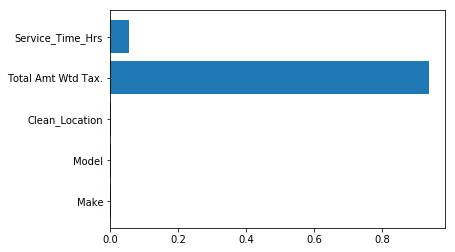

In [34]:
plt.barh(list(X),list(dt.feature_importances_))

In [35]:
### Cross Validation Score

dt_cv_score=cross_val_score(estimator=dt,X=X,y=y,cv=5)

print(dt_cv_score.mean())

0.8326265605398039


### Random Forest Classifier

In [36]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)

In [37]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0)

In [38]:
y_pred_rfc=rfc.predict(X_test)

In [39]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      4825
           1       0.87      1.00      0.93      9834
           2       0.72      0.68      0.70      4868

    accuracy                           0.84     19527
   macro avg       0.84      0.79      0.81     19527
weighted avg       0.85      0.84      0.84     19527



In [40]:
accuracy_score(y_test,y_pred_rfc)

0.843857223331797

<BarContainer object of 5 artists>

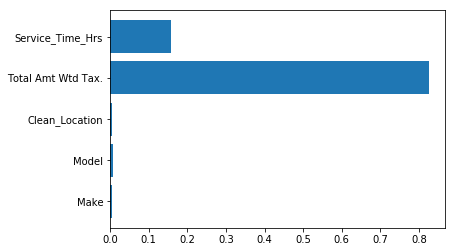

In [41]:
plt.barh(list(X),list(rfc.feature_importances_))

In [42]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [43]:
score.mean()

0.8095188981571342

### XgBoost Classifier

In [44]:
xgb=XGBClassifier()

In [45]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
y_pred_xgb=xgb.predict(X_test)

In [47]:
accuracy_score(y_test,y_pred_xgb)

0.8588620883904338

In [48]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4825
           1       0.89      0.98      0.94      9834
           2       0.74      0.72      0.73      4868

    accuracy                           0.86     19527
   macro avg       0.85      0.82      0.83     19527
weighted avg       0.86      0.86      0.86     19527



In [49]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)

In [50]:
scores_xgb.mean()

0.7795133992440462